In [1]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import shap
from IPython.display import HTML, display
import matplotlib.dates as mdates
from scipy.stats import pearsonr, spearmanr
from scipy.fft import fft, fftfreq
from sklearn.linear_model import LinearRegression
import sys
import os

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
pipeline_path = os.path.abspath('../pipeline')
if pipeline_path not in sys.path:
    sys.path.append(pipeline_path)

# Now import your modules
import otter_config as cfg
from otter_pipeline_function_definitions import (
    load_and_clean_otter_data,
    process_valve_data,
    valve_fluid_usage_calc,
    process_fcv,
    process_pcv,
    convert_tank_levels,
    process_umbilical_charges,
    system_fluid_consumption,
    add_external_losses,
    add_external_loss_moving_averages,
    add_daily_ewm_to_minutely_df,
    add_baseline_columns,
    add_pressure_deltas,
    add_pump_run_cumulatives,
    add_slope_features,
    clean_dataframe,
    run_full_pipeline,
    compute_baseline_drift
)

In [3]:
#File Paths
parquet_path = r"C:\Users\rosst\OneDrive\Control Integrity\Data\Otter 2003 to 2024 with PCV and COV\Parquet_Clean_Output\Otter_All_Combined_PCV.parquet" 

#pump_events_path = r"C:\Users\rosst\OneDrive\Control Integrity\otter-hydraulic-system\data\pump_run_events.csv"

# Processd rop lsop deata. This took 36 hourrs to run
#drop_slope_data_path= r"C:\Users\rosst\OneDrive\Control Integrity\otter-hydraulic-system\data\Slope_Features_Only.parquet"

In [4]:
df_all_otter = run_full_pipeline(
    parquet_path=cfg.parquet_path,
    columns_to_remove=cfg.columns_to_remove,
    valve_columns=cfg.valve_columns,
    valve5_volume=cfg.valve5_volume,
    valve2_volume=cfg.valve2_volume,
    valve_hp_volume=cfg.valve_hp_volume,
    pcv_columns=cfg.pcv_columns,
    thresholds=cfg.thresholds,
    pump_events_path=cfg.pump_events_path,
    valve_transition_cols=cfg.valve_transition_cols,
    drop_slope_data_path=cfg.drop_slope_data_path
)

Loaded 11046261 rows × 52 cols
✅ Transition tracking columns created and combined metrics computed.
✅ FCV processing complete: full steps & fluid usage added.
✅ PCV processing complete: steps & fluid usage added.
✅ Tank levels converted to litres: HPU_SPLY_LEV_L & HPU_RET_LEV_L
Dropped 1288 duplicate rows from slope_df.


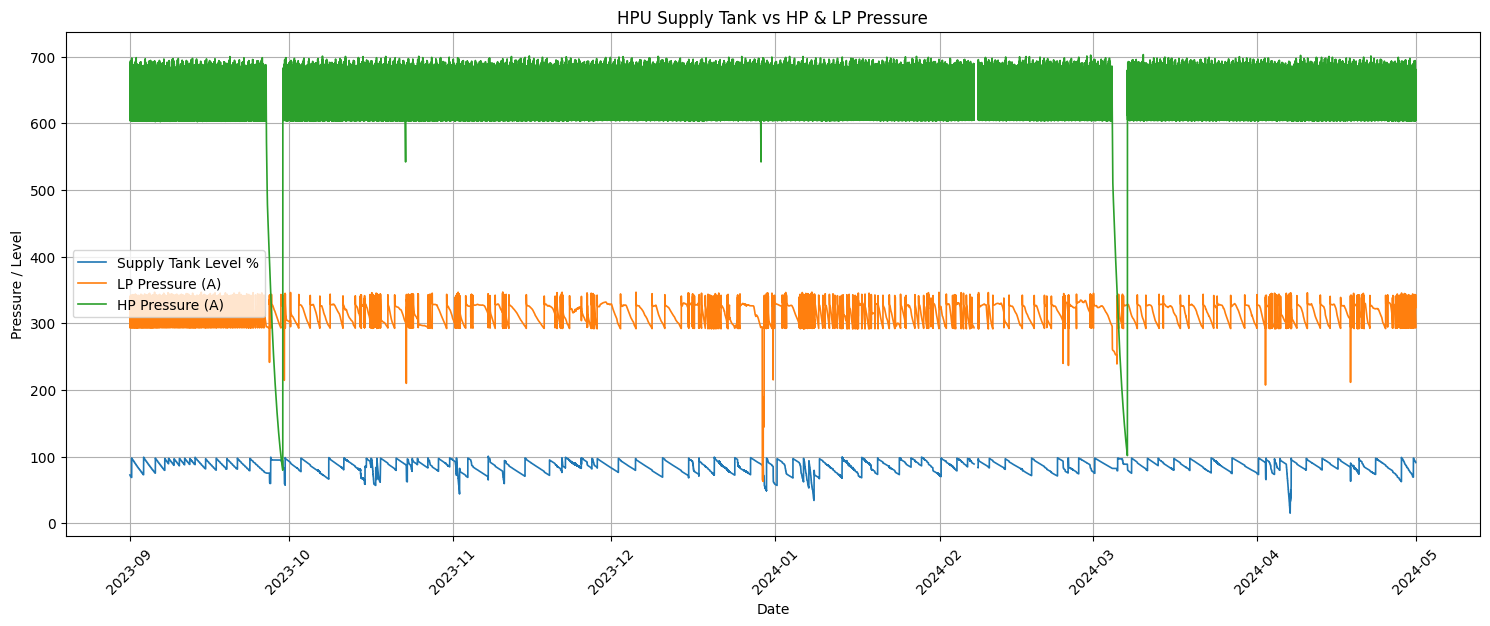

In [5]:

#Plot relevant data points 
supply_col = 'HPU_SPLY_LEV'
lp_pressure_col = 'HPU_LP_A_SPLY'
hp_pressure_col = 'HPU_HP_A_SPLY'

# Filter 2 yhears
start_date = '2023-09-01'
end_date = '2024-04-30'
df_plot = df_all_otter.loc[start_date:end_date, [supply_col, lp_pressure_col, hp_pressure_col]]

# Plot
plt.figure(figsize=(15, 6))
plt.plot(df_plot.index, df_plot[supply_col], label='Supply Tank Level %', linewidth=1.2)
plt.plot(df_plot.index, df_plot[lp_pressure_col], label='LP Pressure (A)', linewidth=1.2)
plt.plot(df_plot.index, df_plot[hp_pressure_col], label='HP Pressure (A)', linewidth=1.2)

plt.title('HPU Supply Tank vs HP & LP Pressure')
plt.xlabel('Date')
plt.ylabel('Pressure / Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)  # rotate for better readability
plt.show()

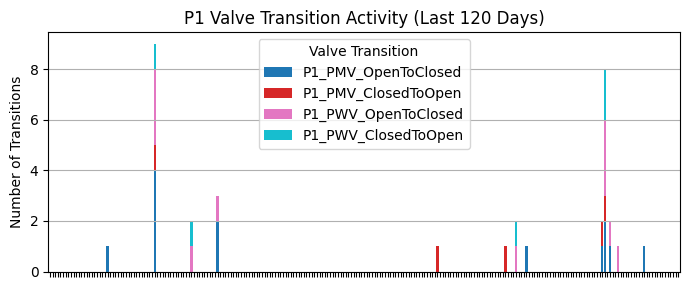

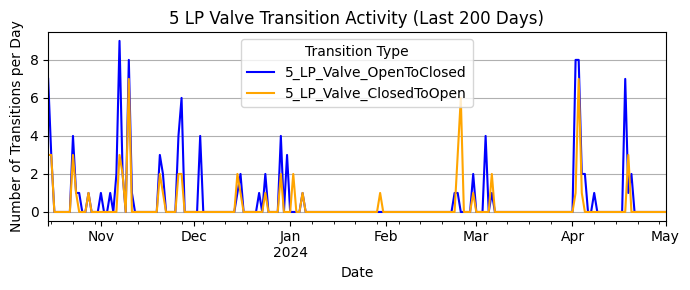

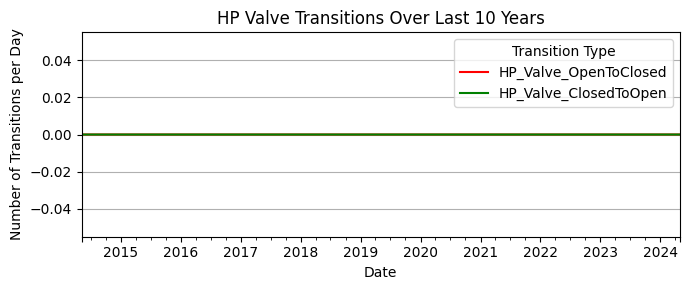

In [6]:
#Plot Valve Data
df_plot = df_all_otter[['P1_PMV_OpenToClosed', 'P1_PMV_ClosedToOpen',
                        'P1_PWV_OpenToClosed', 'P1_PWV_ClosedToOpen']].last('240D')

# Resample to daily counts
daily_counts = df_plot.resample('D').sum()

# Plot
fig, ax = plt.subplots(figsize=(7, 3))
daily_counts.plot(kind='bar', stacked=True, ax=ax, colormap='tab10', width=0.9)

# Clean up formatting
plt.title("P1 Valve Transition Activity (Last 120 Days)")
plt.ylabel("Number of Transitions")
ax.set_xlabel("")  # Remove x-axis label
ax.tick_params(axis='x', labelbottom=False)  # Remove x-axis tick labels
plt.grid(True, axis='y')
plt.tight_layout()
plt.legend(title="Valve Transition")
plt.show()

# Resample daily totals
lp5_valve_trend = df_all_otter[['5_LP_Valve_OpenToClosed', '5_LP_Valve_ClosedToOpen']].resample('D').sum().last('200D')

# Plotting
fig, ax = plt.subplots(figsize=(7, 3))
lp5_valve_trend.plot(ax=ax, color=['blue', 'orange'])

plt.title("5 LP Valve Transition Activity (Last 200 Days)")
plt.ylabel("Number of Transitions per Day")
plt.xlabel("Date")
plt.grid(True, axis='y')
plt.legend(title="Transition Type")
plt.tight_layout()
plt.show()

hp_valve_trend = df_all_otter[['HP_Valve_OpenToClosed', 'HP_Valve_ClosedToOpen']].resample('D').sum().last('3650D')

# Plot
fig, ax = plt.subplots(figsize=(7, 3))
hp_valve_trend.plot(ax=ax, color=['red', 'green'])

plt.title("HP Valve Transitions Over Last 10 Years")
plt.ylabel("Number of Transitions per Day")
plt.xlabel("Date")
plt.grid(True, axis='y')
plt.legend(title="Transition Type")
plt.tight_layout()
plt.show()

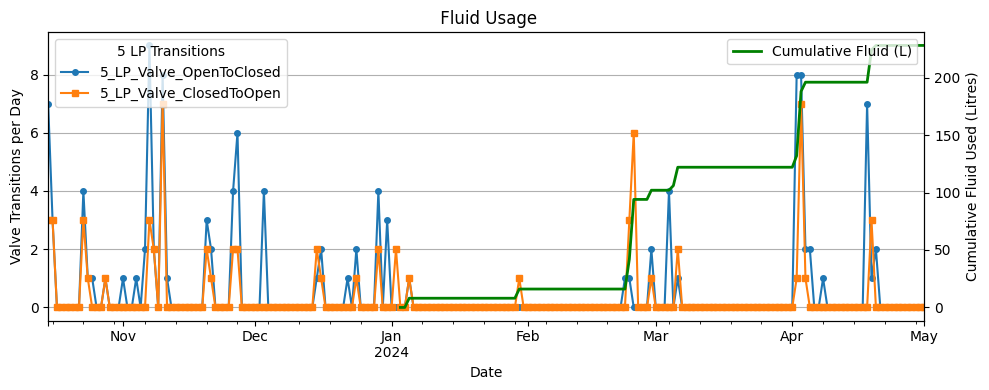

In [7]:
# --- Plot Valve Fluid Usage
valve_counts = (
    df_all_otter[['5_LP_Valve_OpenToClosed', '5_LP_Valve_ClosedToOpen']]
    .resample('D')
    .sum()
    .last('200D')
)

daily_fluid = (
    df_all_otter['Valve_Operation_Fluid']
    .resample('D')
    .sum()
    .last('120D')
)
cum_fluid = daily_fluid.cumsum()

fig, ax1 = plt.subplots(figsize=(10, 4))


valve_counts.plot(ax=ax1, style=['-o', '-s'], markersize=4)
ax1.set_ylabel("Valve Transitions per Day")
ax1.set_xlabel("Date")
ax1.grid(axis='y')
ax1.legend(title="5 LP Transitions", loc='upper left')


ax2 = ax1.twinx()
ax2.plot(cum_fluid.index, cum_fluid.values, color='green', linewidth=2, label='Cumulative Fluid (L)')
ax2.set_ylabel("Cumulative Fluid Used (Litres)")
ax2.legend(loc='upper right')

plt.title(" Fluid Usage")
plt.tight_layout()
plt.show()

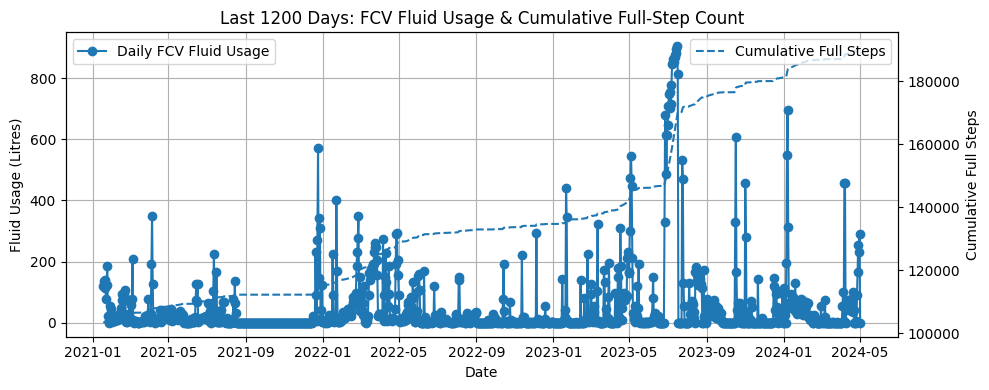

In [8]:
daily_fcv_fluid = (
    df_all_otter['FCV_Fluid_Usage']
    .resample('D')
    .sum()
    .last('1200D')
)

# 3) Daily cumulative full‐step count (last 1200 days)
daily_cum_steps = (
    df_all_otter['FCV_CPI_FullSteps']
    .resample('D')
    .max()
    .last('1200D')
)

# 4) Plot
fig, ax1 = plt.subplots(figsize=(10, 4))

# Fluid usage
ax1.plot(daily_fcv_fluid.index, daily_fcv_fluid.values, marker='o', label='Daily FCV Fluid Usage')
ax1.set_xlabel("Date")
ax1.set_ylabel("Fluid Usage (Litres)")
ax1.grid(True)
ax1.legend(loc='upper left')

# Cumulative full steps on secondary axis
ax2 = ax1.twinx()
ax2.plot(daily_cum_steps.index, daily_cum_steps.values, linestyle='--', label='Cumulative Full Steps')
ax2.set_ylabel("Cumulative Full Steps")
ax2.legend(loc='upper right')

plt.title("Last 1200 Days: FCV Fluid Usage & Cumulative Full-Step Count")
plt.tight_layout()
plt.show()

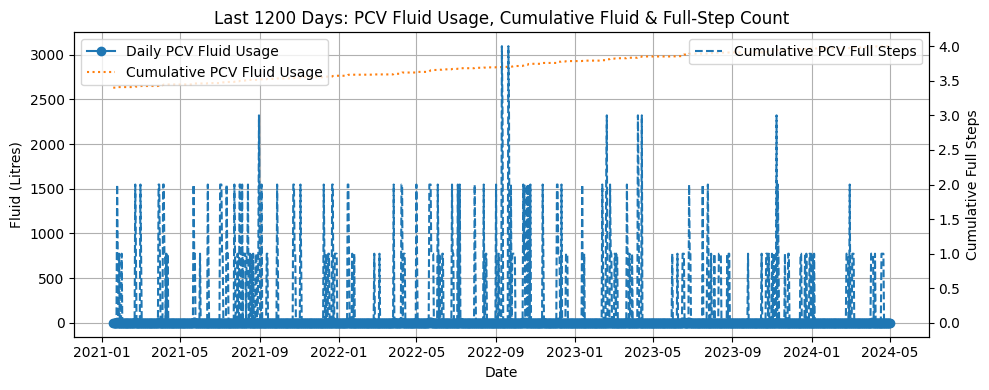

In [9]:
# Plot the PCV DATA

daily_pcv_fluid = (
    df_all_otter['PCV_Fluid_Usage']
    .resample('D')
    .sum()
    .last('1200D')
)

daily_cum_pcv_steps = (
    df_all_otter['PCV_FullSteps']
    .resample('D')
    .max()
    .last('1200D')
)

daily_cum_pcv_fluid = (
    df_all_otter['Cumulative_PCV_Fluid_Usage']
    .resample('D')
    .max()
    .last('1200D')
)

fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(
    daily_pcv_fluid.index,
    daily_pcv_fluid.values,
    marker='o',
    label='Daily PCV Fluid Usage')

ax1.plot(
    daily_cum_pcv_fluid.index,
    daily_cum_pcv_fluid.values,
    linestyle=':',
    label='Cumulative PCV Fluid Usage'
)

ax1.set_xlabel("Date")
ax1.set_ylabel("Fluid (Litres)")
ax1.grid(True)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(
    daily_cum_pcv_steps.index,
    daily_cum_pcv_steps.values,
    linestyle='--',
    label='Cumulative PCV Full Steps'
)
ax2.set_ylabel("Cumulative Full Steps")
ax2.legend(loc='upper right')

plt.title("Last 1200 Days: PCV Fluid Usage, Cumulative Fluid & Full-Step Count")
plt.tight_layout()
plt.show()


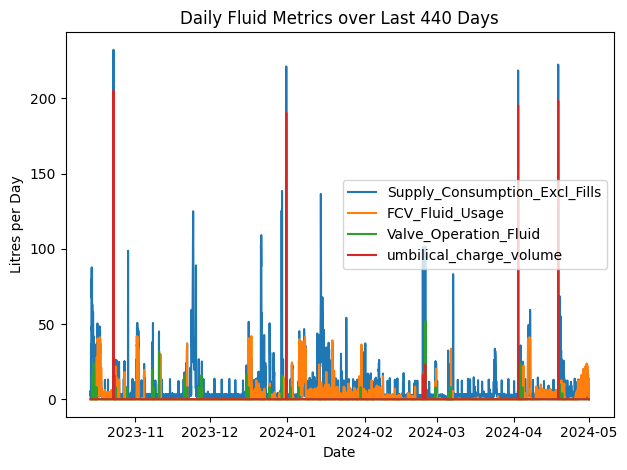

In [10]:
# Plot of calcaulted fluiod usage - 

# Restrict to the most recent 120 days
df_recent = df_all_otter.last('200D')

# 1. Daily sums for each metric #Supply_Consumption_Excl_Fills
daily = df_recent[['Supply_Consumption_Excl_Fills',
                   'FCV_Fluid_Usage',
                   'Valve_Operation_Fluid','umbilical_charge_volume'
                   ]].resample('H').sum()

# 2. Daily cumulative values (take last value of each day)
cum = df_recent[[ 'Cumulative_FCV_Fluid_Usage',
                 'Cumulative_Valve_Operation_Fluid','umbilical_charge_volume'
                ]].resample('H').last()

# Plot A: Daily metrics
plt.figure()
for col in daily.columns:
    plt.plot(daily.index, daily[col], label=col)
plt.title("Daily Fluid Metrics over Last 440 Days")
plt.xlabel("Date")
plt.ylabel("Litres per Day")
plt.legend()
plt.tight_layout()
plt.show()

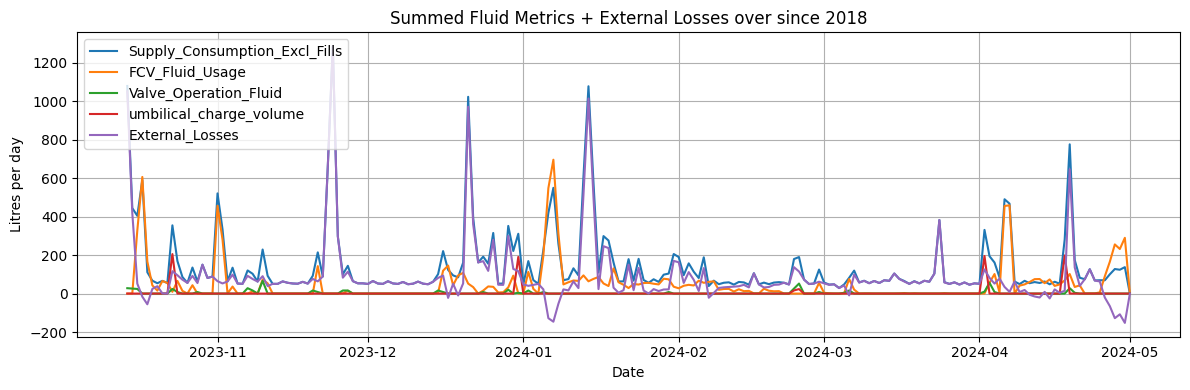

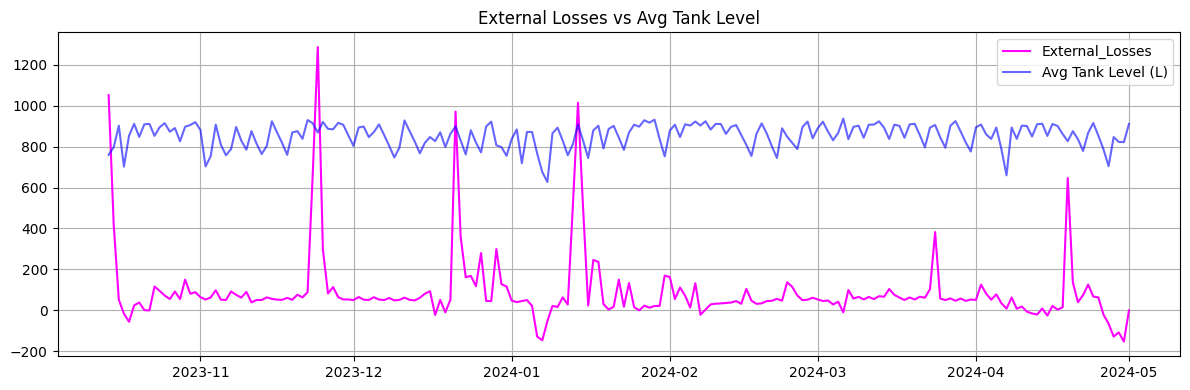

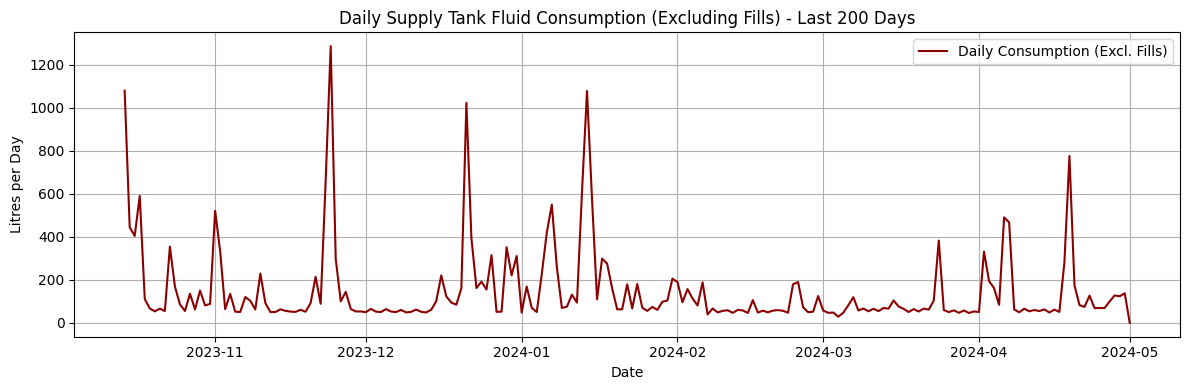

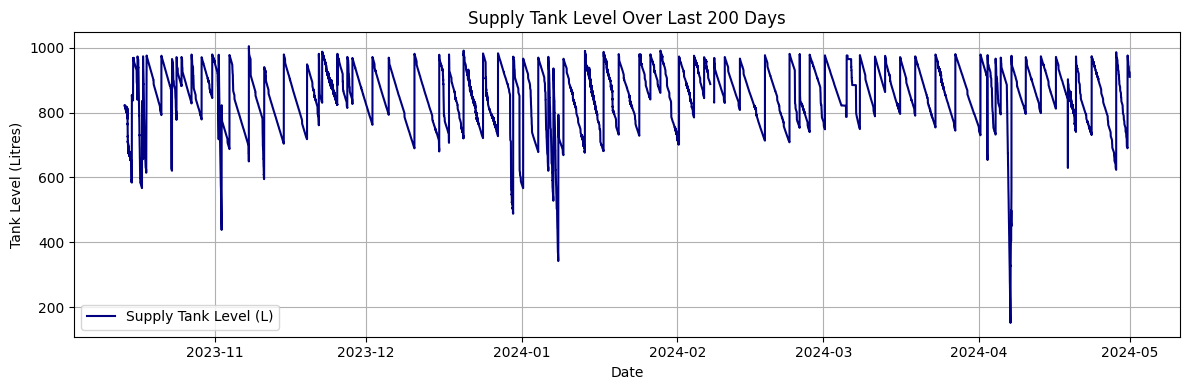

In [11]:
# 0) Make sure your index is datetime and sorted
df_all_otter.index = pd.to_datetime(df_all_otter.index)
df_all_otter.sort_index(inplace=True)

# 1) Restrict to the last 440 days
df_recent = df_all_otter.last('200D')

# 2) Hourly‐sum each metric (gives litres per hour)
daily = df_recent[[
    'Supply_Consumption_Excl_Fills',
    'FCV_Fluid_Usage',
    'Valve_Operation_Fluid',
    'umbilical_charge_volume'
]].resample('D').sum()

# 3) Compute External Losses = Total – (FCV + Valve + Umbilical)
daily['External_Losses'] = (
      daily['Supply_Consumption_Excl_Fills']
    - daily['FCV_Fluid_Usage']
    - daily['Valve_Operation_Fluid']
    - daily['umbilical_charge_volume']
)

# 4) Plot
plt.figure(figsize=(12, 4))
for col in ['Supply_Consumption_Excl_Fills', 'FCV_Fluid_Usage',
            'Valve_Operation_Fluid', 'umbilical_charge_volume',
            'External_Losses']:
    plt.plot(daily.index, daily[col], label=col)

plt.title("Summed Fluid Metrics + External Losses over since 2018")
plt.xlabel("Date")
plt.ylabel("Litres per day")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

df_level = df_recent['HPU_SPLY_LEV_L'].resample('D').mean()

plt.figure(figsize=(12, 4))
plt.plot(daily.index, daily['External_Losses'], color='magenta', label='External_Losses')
plt.plot(df_level.index, df_level, color='blue', alpha=0.6, label='Avg Tank Level (L)')
plt.legend()
plt.grid()
plt.title("External Losses vs Avg Tank Level")
plt.tight_layout()
plt.show()

daily_consumption = df_recent['Supply_Consumption_Excl_Fills'].resample('D').sum()

# 5) Plot
plt.figure(figsize=(12, 4))
plt.plot(daily_consumption.index, daily_consumption, label='Daily Consumption (Excl. Fills)', color='darkred')
plt.title('Daily Supply Tank Fluid Consumption (Excluding Fills) - Last 200 Days')
plt.xlabel('Date')
plt.ylabel('Litres per Day')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.figure(figsize=(12, 4))
plt.plot(df_recent.index, df_recent['HPU_SPLY_LEV_L'], label='Supply Tank Level (L)', color='navy')
plt.title('Supply Tank Level Over Last 200 Days')
plt.xlabel('Date')
plt.ylabel('Tank Level (Litres)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

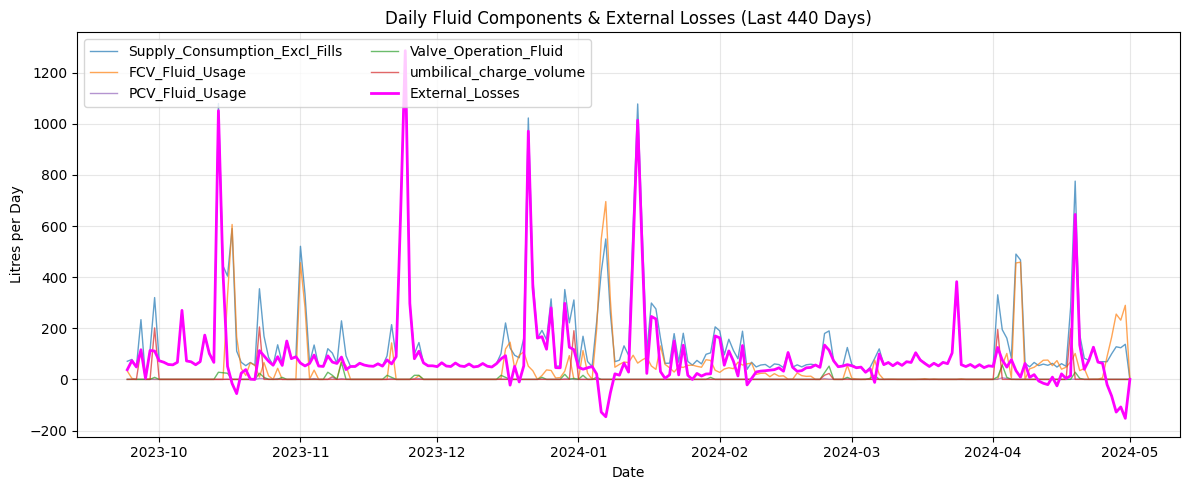

In [12]:

# 1) Ensure datetime index & sort
df_all_otter.index = pd.to_datetime(df_all_otter.index, errors='coerce')
df_all_otter.sort_index(inplace=True)

# 2) Slice to last 440 days
df_recent = df_all_otter.last('220D')

# 3) Daily sums (L/day)
daily = df_recent[[
    'Supply_Consumption_Excl_Fills',
    'FCV_Fluid_Usage',
    'PCV_Fluid_Usage',                # <-- added PCV
    'Valve_Operation_Fluid',
    'umbilical_charge_volume'
]].resample('D').sum()

# 4) Compute External_Losses inline
daily['External_Losses'] = (
      daily['Supply_Consumption_Excl_Fills']
    - daily['FCV_Fluid_Usage']
    - daily['PCV_Fluid_Usage']        # <-- subtract PCV
    - daily['Valve_Operation_Fluid']
    - daily['umbilical_charge_volume']
)

# 5) Plot
plt.figure(figsize=(12, 5))

for col, color, lw, alpha in [
    ('Supply_Consumption_Excl_Fills',        'C0', 1, 0.7),
    ('FCV_Fluid_Usage',                'C1', 1, 0.7),
    ('PCV_Fluid_Usage',                'C4', 1, 0.7),  # PCV in C4
    ('Valve_Operation_Fluid',          'C2', 1, 0.7),
    ('umbilical_charge_volume','C3', 1, 0.7),
    ('External_Losses',                'magenta', 2, 1.0),
]:
    plt.plot(
        daily.index,
        daily[col],
        label=col,
        color=color,
        linewidth=lw,
        alpha=alpha
    )

plt.title("Daily Fluid Components & External Losses (Last 440 Days)")
plt.xlabel("Date")
plt.ylabel("Litres per Day")
plt.legend(loc='upper left', ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


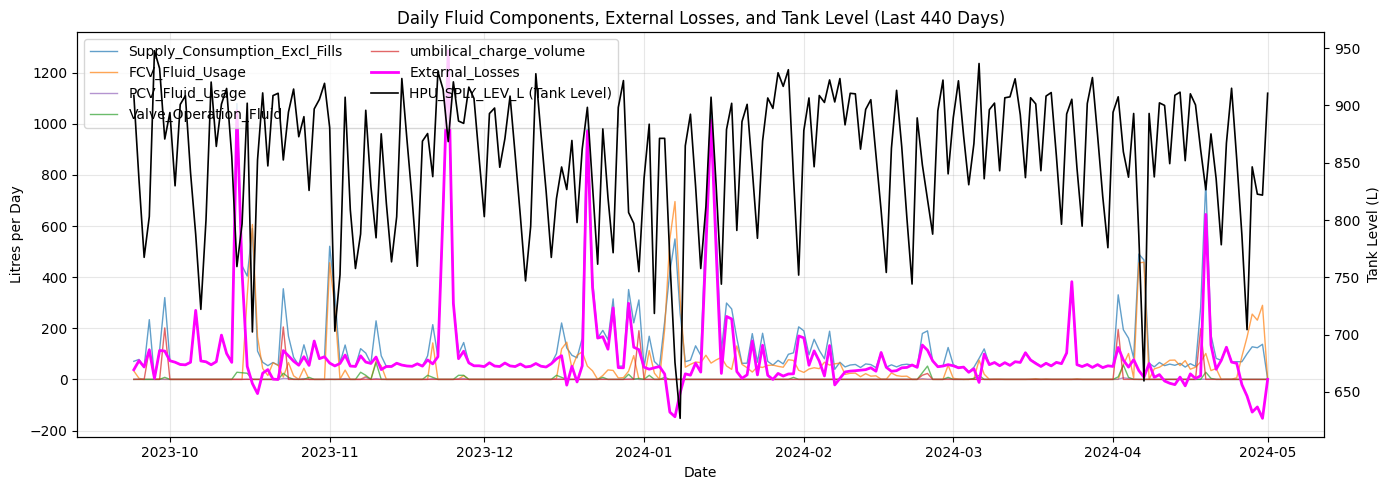

In [13]:
# 1) Slice same 440-day window of raw tank level data (not resampled)
tank_level = df_recent['HPU_SPLY_LEV_L'].copy()

# 2) Resample to daily mean for visibility (or 'min'/'max' depending on what you want)
tank_level_daily = tank_level.resample('D').mean()

# 3) Plot with dual y-axis
fig, ax1 = plt.subplots(figsize=(14, 5))

# Primary axis — fluid usage & losses
for col, color, lw, alpha in [
    ('Supply_Consumption_Excl_Fills',        'C0', 1, 0.7),
    ('FCV_Fluid_Usage',                'C1', 1, 0.7),
    ('PCV_Fluid_Usage',                'C4', 1, 0.7),
    ('Valve_Operation_Fluid',          'C2', 1, 0.7),
    ('umbilical_charge_volume',        'C3', 1, 0.7),
    ('External_Losses',                'magenta', 2, 1.0),
]:
    ax1.plot(
        daily.index,
        daily[col],
        label=col,
        color=color,
        linewidth=lw,
        alpha=alpha
    )

ax1.set_ylabel("Litres per Day")
ax1.set_xlabel("Date")
ax1.grid(alpha=0.3)

# Secondary axis — tank level
ax2 = ax1.twinx()
ax2.plot(
    tank_level_daily.index,
    tank_level_daily,
    color='black',
    linewidth=1.2,
    label='HPU_SPLY_LEV_L (Tank Level)'
)
ax2.set_ylabel("Tank Level (L)", color='black')

# Combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', ncol=2)

plt.title("Daily Fluid Components, External Losses, and Tank Level (Last 440 Days)")
plt.tight_layout()
plt.show()

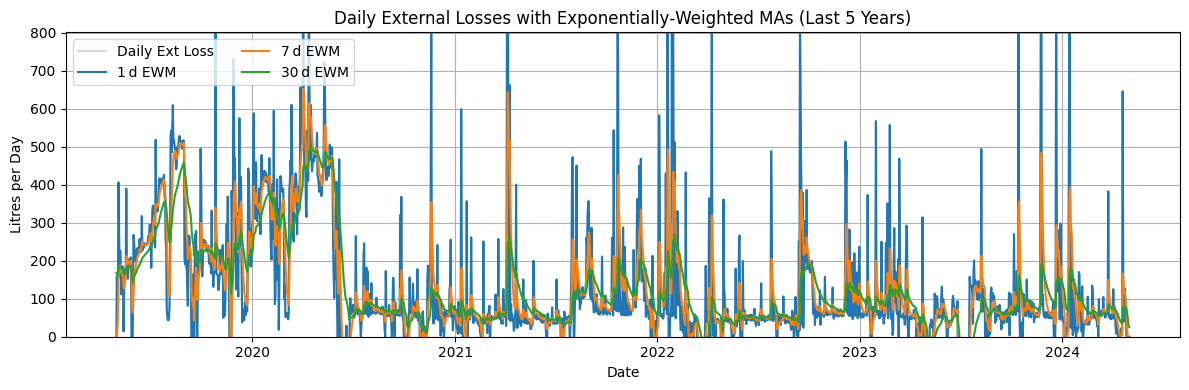

In [14]:
# 1) Build your daily External Losses series (L/day)
#    If you haven’t already, do:
df_all_otter.index = pd.to_datetime(df_all_otter.index, errors='coerce')
daily = (
    df_all_otter['External_Losses']
      .resample('D')
      .sum()
      .to_frame(name='Ext_Loss_L_per_day')
)

# 2) Compute EWMs with spans of 1, 7, and 30 days
for span in [1, 7, 30]:
    daily[f'EWM_{span}d'] = (
        daily['Ext_Loss_L_per_day']
             .ewm(span=span, adjust=False)
             .mean()
    )

# 3) Zoom into the last 5 years
cutoff = daily.index.max() - pd.DateOffset(years=5)
d5 = daily.loc[cutoff:]

# 4) Plot
plt.figure(figsize=(12, 4))

# raw daily loss
plt.plot(
    d5.index,
    d5['Ext_Loss_L_per_day'],
    color='gray',
    alpha=0.3,
    label='Daily Ext Loss'
)

# EWM curves
colors = ['C0','C1','C2']
for span, c in zip([1, 7, 30], colors):
    plt.plot(
        d5.index,
        d5[f'EWM_{span}d'],
        color=c,
        linewidth=1.5,
        label=f'{span} d EWM'
    )

plt.title("Daily External Losses with Exponentially‑Weighted MAs (Last 5 Years)")
plt.xlabel("Date")
plt.ylabel("Litres per Day")

# set y‑limit to just above the 99th percentile of raw daily loss
upper = d5['Ext_Loss_L_per_day'].quantile(0.99) * 1.1
plt.ylim(0, upper)

plt.legend(loc='upper left', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


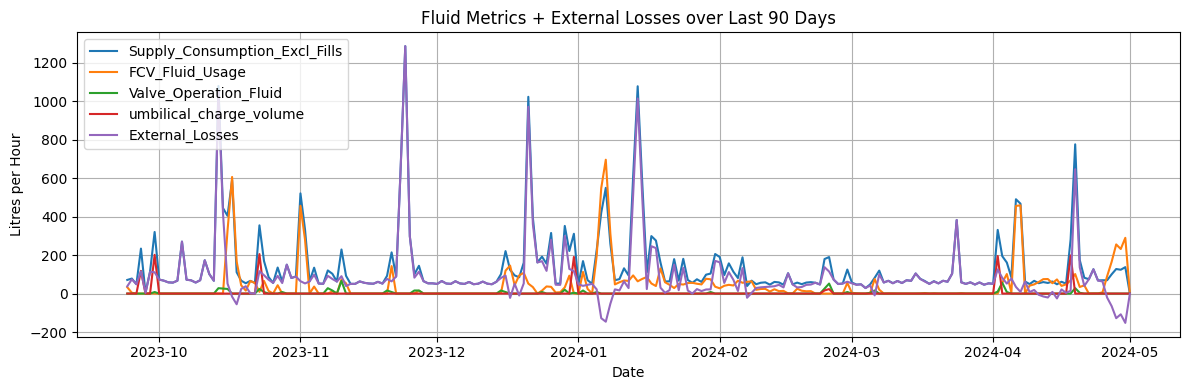

In [15]:
df_recent = df_all_otter.last('220D')

# 2) Hourly‐sum each metric (gives litres per hour)
daily = df_recent[[
    'Supply_Consumption_Excl_Fills',
    'FCV_Fluid_Usage',
    'Valve_Operation_Fluid',
    'umbilical_charge_volume'
]].resample('D').sum()

# 3) Compute External Losses = Total – (FCV + Valve + Umbilical)
daily['External_Losses'] = (
      daily['Supply_Consumption_Excl_Fills']
    - daily['FCV_Fluid_Usage']
    - daily['Valve_Operation_Fluid']
    - daily['umbilical_charge_volume']
)

# 4) Plot
plt.figure(figsize=(12, 4))
for col in ['Supply_Consumption_Excl_Fills', 'FCV_Fluid_Usage',
            'Valve_Operation_Fluid', 'umbilical_charge_volume',
            'External_Losses']:
    plt.plot(daily.index, daily[col], label=col)

plt.title("Fluid Metrics + External Losses over Last 90 Days")
plt.xlabel("Date")
plt.ylabel("Litres per Hour")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

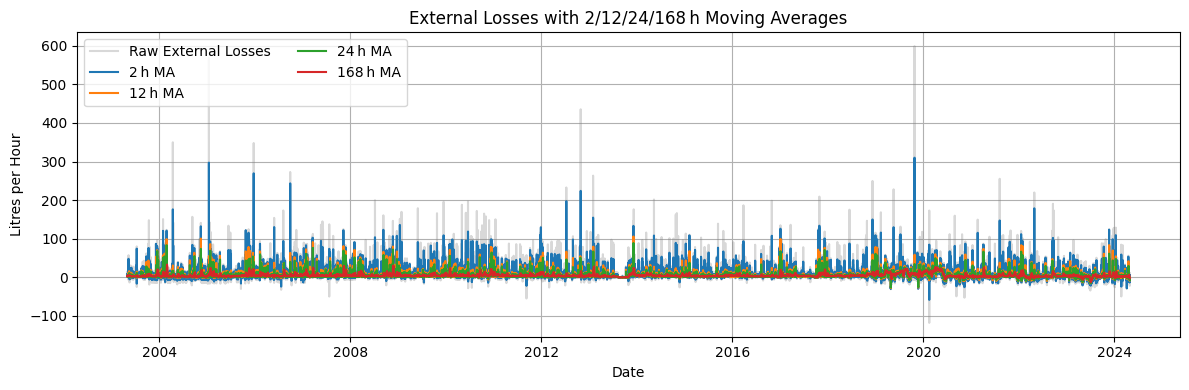

In [16]:
hourly = df_all_otter[[
    'Supply_Consumption_Excl_Fills',
    'FCV_Fluid_Usage',
    'Valve_Operation_Fluid',
    'umbilical_charge_volume'
]].resample('H').sum()

hourly['External_Losses'] = (
      hourly['Supply_Consumption_Excl_Fills']
    - hourly['FCV_Fluid_Usage']
    - hourly['Valve_Operation_Fluid']
    - hourly['umbilical_charge_volume']
)

# --- 2) Compute moving averages (simple MA) ---
for w in [2, 12, 24, 168]:
    hourly[f'MA_{w}h'] = (
        hourly['External_Losses']
              .rolling(window=w, min_periods=1)
              .mean()
    )

# --- 3) Plot raw + MAs ---
plt.figure(figsize=(12, 4))

# raw series
plt.plot(hourly.index, hourly['External_Losses'],
         color='gray', alpha=0.3, label='Raw External Losses')

# each rolling mean
for w, col in zip([2, 12, 24, 168], ['C0', 'C1', 'C2', 'C3']):
    plt.plot(hourly.index, hourly[f'MA_{w}h'],
             label=f'{w} h MA', linewidth=1.5)

plt.title("External Losses with 2/12/24/168 h Moving Averages")
plt.xlabel("Date")
plt.ylabel("Litres per Hour")
plt.legend(loc='upper left', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

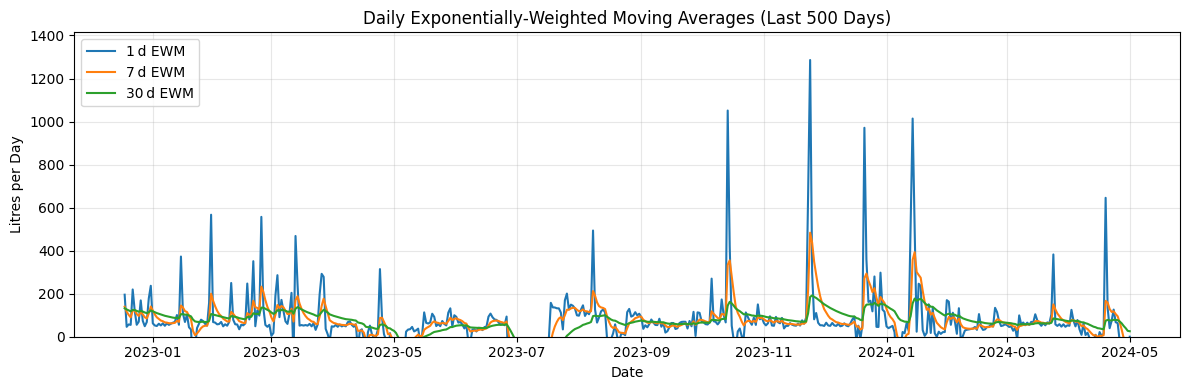

In [17]:
# 1) Ensure datetime index & sort
df_all_otter.index = pd.to_datetime(df_all_otter.index, errors='coerce')
df_all_otter.sort_index(inplace=True)

# 2) Slice to the last 500 days
df500 = df_all_otter.last('500D')

# 3) Resample the EWM columns to daily (so you get one point per day)
daily_ewm = df500[['EWM_1d','EWM_7d','EWM_30d']].resample('D').last()

# 4) Plot
plt.figure(figsize=(12, 4))
for span, col, color in [
    (1,  'EWM_1d',  'C0'),
    (7,  'EWM_7d',  'C1'),
    (30, 'EWM_30d','C2'),
]:
    plt.plot(
        daily_ewm.index,
        daily_ewm[col],
        color=color,
        linewidth=1.5,
        label=f'{span} d EWM'
    )

plt.title("Daily Exponentially‑Weighted Moving Averages (Last 500 Days)")
plt.xlabel("Date")
plt.ylabel("Litres per Day")
plt.ylim(0, daily_ewm.max().max()*1.1)  # give 10% headroom
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

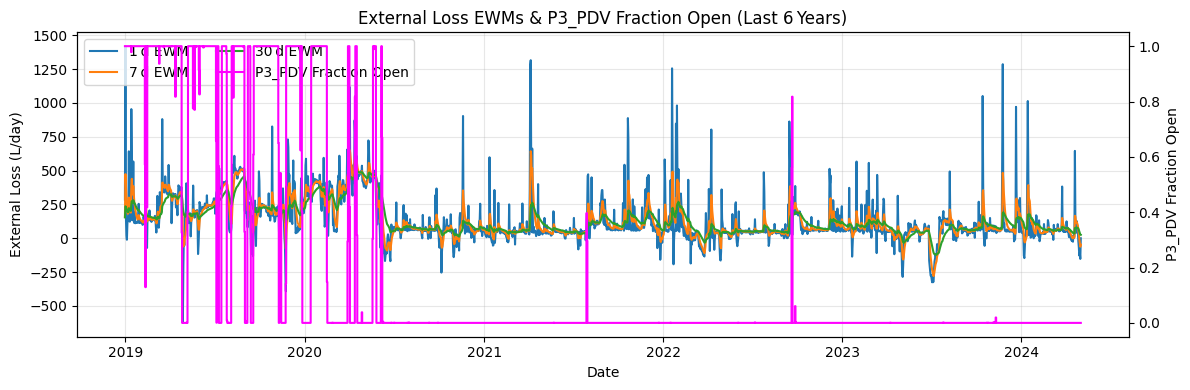

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 0) Make sure your main DF is datetime‑indexed & sorted
df_all_otter.index = pd.to_datetime(df_all_otter.index, errors='coerce')
df_all_otter.sort_index(inplace=True)

# 1) Create a numeric “fraction open” series from your state column
#    Map 'OPEN' or 'FAULT' → 1.0, everything else (e.g. 'CLOSED') → 0.0
df_all_otter['P3_PDV_num'] = (
    df_all_otter['P3_PDV']
    .map({'OPEN': 1.0, 'FAULT': 1.0, 'CLOSED': 0.0})
    .fillna(0.0)
)

# 2) Slice the last 6 years of data
df6y = df_all_otter.last('6Y')

# 3) Resample your EWMs to daily (take the last value each day)
daily_ewm = df6y[['EWM_1d','EWM_7d','EWM_30d']].resample('D').last()

# 4) Build daily P3_PDV fraction‑open, aligned to the same dates
daily_p3 = (
    df_all_otter['P3_PDV_num']
    .resample('D')
    .mean()
    .loc[daily_ewm.index]
)

# 5) Plot
fig, ax1 = plt.subplots(figsize=(12, 4))

# — left axis: EWMs
for span, col in zip([1,7,30], ['EWM_1d','EWM_7d','EWM_30d']):
    ax1.plot(
        daily_ewm.index,
        daily_ewm[col],
        linewidth=1.5,
        label=f'{span} d EWM'
    )

ax1.set_ylabel("External Loss (L/day)")
ax1.set_xlabel("Date")
ax1.set_title("External Loss EWMs & P3_PDV Fraction Open (Last 6 Years)")
ax1.grid(alpha=0.3)

# — right axis: P3_PDV fraction open
ax2 = ax1.twinx()
ax2.step(
    daily_p3.index,
    daily_p3.values,
    where='mid',
    color='magenta',    # ← here!
    linewidth=1.5,
    label='P3_PDV Fraction Open'
)
ax2.set_ylabel("P3_PDV Fraction Open")
ax2.set_ylim(-0.05, 1.05)

# — Combine legends
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left', ncol=2)

# — Beautify dates
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator())
)

plt.tight_layout()
plt.show()


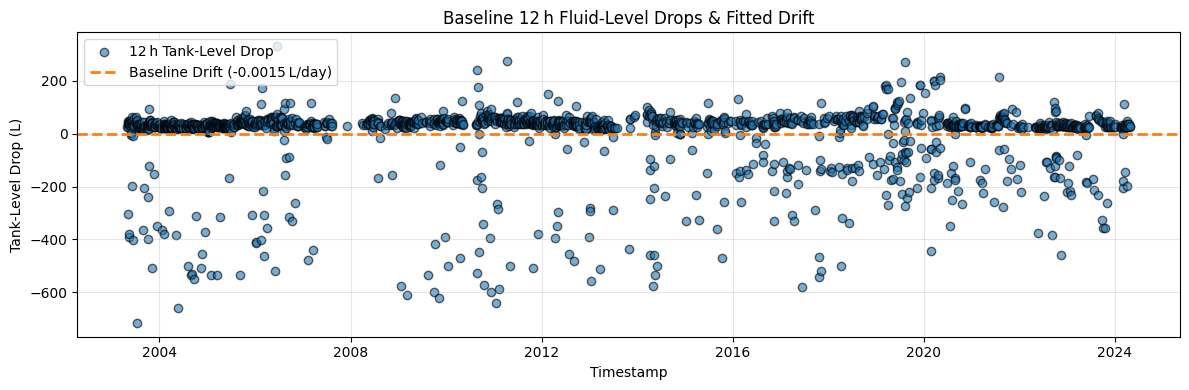

In [19]:
# 1) Extract rows where a baseline drop was recorded
starts = df_all_otter.dropna(subset=['baseline_drop_L'])

# 2) Get the unique drift value (same on every row)
drift = df_all_otter['baseline_drift_L_per_day'].iloc[0]

# 3) Plot
fig, ax = plt.subplots(figsize=(12, 4))

# Scatter the 12 h drops at their start timestamps
ax.scatter(
    starts.index,
    starts['baseline_drop_L'],
    alpha=0.6,
    edgecolor='k',
    label='12 h Tank‑Level Drop'
)

# Draw a horizontal line for the drift (L/day)
ax.axhline(
    y=drift,
    color='C1',
    linestyle='--',
    linewidth=2,
    label=f"Baseline Drift ({drift:.4f} L/day)"
)

# 4) Labels & grid
ax.set_title("Baseline 12 h Fluid‑Level Drops & Fitted Drift")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Tank‑Level Drop (L)")
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# 5) Nice date formatting
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

plt.tight_layout()
plt.show()


Median drop     = 35.86 L
95th percentile = 69.48 L


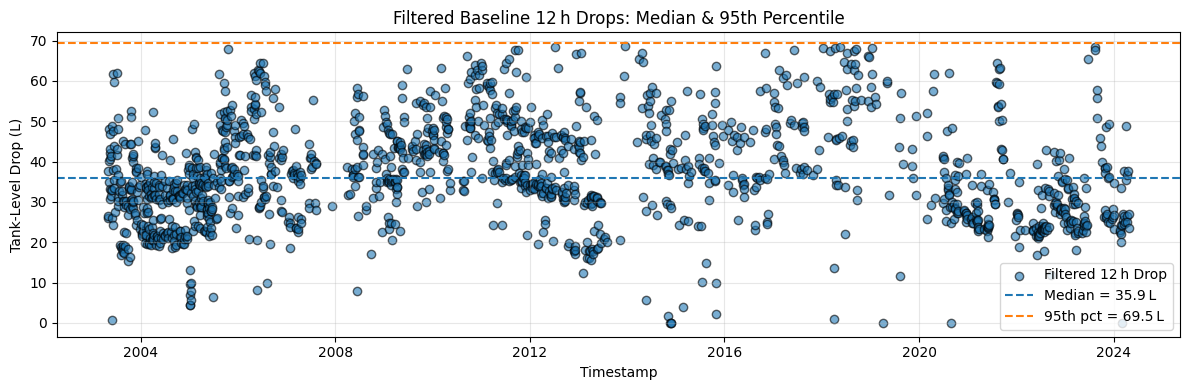

In [20]:

# --- 1) Compute the 95th percentile on your recorded drops ---
drops   = starts['baseline_drop_L']
pct95   = drops.quantile(0.95)

# --- 2) Filter out negatives & >95th‑pct outliers ---
clean = starts[
    (drops >= 0) &
    (drops <= pct95)
].copy()

# --- 3) Compute the summary stats ---
median_drop = clean['baseline_drop_L'].median()
pct95_val   = pct95

print(f"Median drop     = {median_drop:.2f} L")
print(f"95th percentile = {pct95_val:.2f} L")

# --- 4) Plot the cleaned drops + lines ---
fig, ax = plt.subplots(figsize=(12, 4))

# scatter the filtered drops
ax.scatter(
    clean.index,               # timestamp index
    clean['baseline_drop_L'],  # filtered 12 h drops
    alpha=0.6,
    edgecolor='k',
    label='Filtered 12 h Drop'
)

# horizontal lines for median & 95th pct
ax.axhline(median_drop, color='C0', linestyle='--',
           label=f'Median = {median_drop:.1f} L')
ax.axhline(pct95_val,   color='C1', linestyle='--',
           label=f'95th pct = {pct95_val:.1f} L')

# labels, legend, grid
ax.set_title("Filtered Baseline 12 h Drops: Median & 95th Percentile")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Tank‑Level Drop (L)")
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# nice date formatting
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator())
)

plt.tight_layout()
plt.show()


2003: Median drop = 31.04 L
2004: Median drop = 28.03 L
2005: Median drop = 34.33 L
2006: Median drop = 41.22 L
2007: Median drop = 35.87 L
2008: Median drop = 38.37 L
2009: Median drop = 41.88 L
2010: Median drop = 48.32 L
2011: Median drop = 45.20 L
2012: Median drop = 34.12 L
2013: Median drop = 29.69 L
2014: Median drop = 40.38 L
2015: Median drop = 38.17 L
2016: Median drop = 34.31 L
2017: Median drop = 40.38 L
2018: Median drop = 51.59 L
2019: Median drop = 35.85 L
2020: Median drop = 28.85 L
2021: Median drop = 27.46 L
2022: Median drop = 24.07 L
2023: Median drop = 26.26 L
2024: Median drop = 24.79 L



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


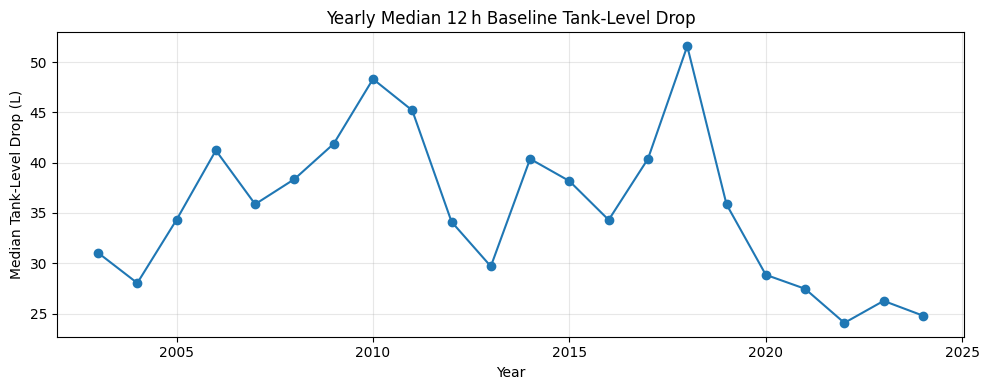

In [21]:
# --- 1) Extract the year from each 12 h‐window start timestamp ---
starts['year'] = pd.to_datetime(starts.index).year

# --- 2) Group by year and compute the median drop ---
yearly_median = (
    starts
    .groupby('year')['baseline_drop_L']
    .median()
    .reset_index(name='median_drop')
)

# --- 3) Print out the results ---
for yr, md in zip(yearly_median['year'], yearly_median['median_drop']):
    print(f"{yr}: Median drop = {md:.2f} L")

# --- 4) Plot the yearly medians ---
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    yearly_median['year'],
    yearly_median['median_drop'],
    marker='o',
    linestyle='-'
)

# Labels, grid, title
ax.set_title("Yearly Median 12 h Baseline Tank‑Level Drop")
ax.set_xlabel("Year")
ax.set_ylabel("Median Tank‑Level Drop (L)")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
## Remove all temp dataframes to reduce memory 

for var_name in dir():
    var = globals()[var_name]
    if isinstance(var, pd.DataFrame):
        size_mb = sys.getsizeof(var) / (1024 ** 2)
        print(f"{var_name:30} {var.shape}  {size_mb:.2f} MB")


clean                          (1529, 164)  3.77 MB
cum                            (4801, 3)  0.15 MB
d5                             (1828, 4)  0.07 MB
daily                          (221, 5)  0.01 MB
daily_counts                   (241, 4)  0.01 MB
daily_ewm                      (1949, 3)  0.06 MB
df500                          (719941, 163)  1776.38 MB
df6y                           (2805065, 164)  6910.56 MB
df_all_otter                   (11046261, 164)  27422.32 MB
df_plot                        (345600, 4)  7.91 MB
df_recent                      (316800, 163)  783.52 MB
hourly                         (184105, 9)  14.05 MB
hp_valve_trend                 (3650, 2)  0.08 MB
lp5_valve_trend                (200, 2)  0.00 MB
starts                         (1908, 165)  4.71 MB
valve_counts                   (200, 2)  0.00 MB
yearly_median                  (22, 2)  0.00 MB


170688

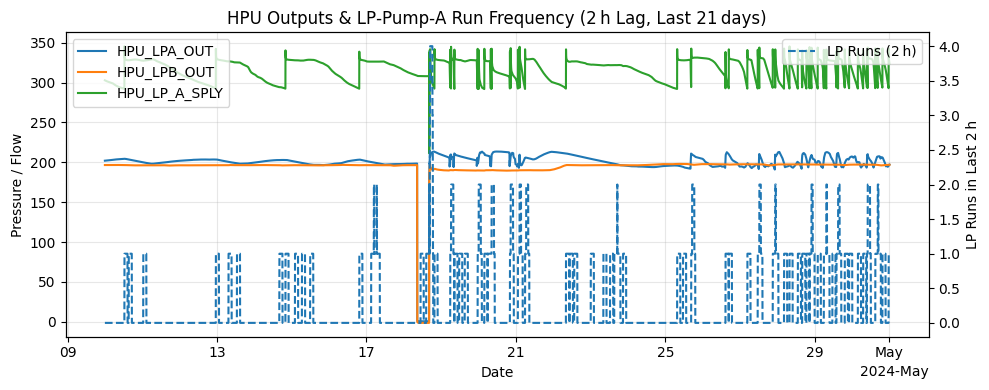

In [35]:


# --- 1) Prepare df_all_otter in‑place (no full copy) ---
df_all_otter.index = pd.to_datetime(df_all_otter.index, errors='coerce')
df_all_otter.sort_index(inplace=True)

# --- 2) Compute LP_Runs_2h on the full series (in‑place) ---
# shift by 120 min (2 h) to get runs started in the last 2 h
df_all_otter['LP_Runs_2h'] = (
    df_all_otter['Cum_LP_Pump_A_Run_Count']
    - df_all_otter['Cum_LP_Pump_A_Run_Count'].shift(120)
).fillna(0)

# --- 3) Slice out just the last 21 days and copy that small chunk ---
end   = df_all_otter.index.max()
start = end - pd.DateOffset(days=21)
df21d = df_all_otter.loc[start:end].copy()

# --- 4) Plot HPU outputs + 2 h run frequency on this small slice ---
fig, ax1 = plt.subplots(figsize=(10, 4))

# Left axis: HPU signals
ax1.plot(df21d.index, df21d['HPU_LPA_OUT'],   label='HPU_LPA_OUT')
ax1.plot(df21d.index, df21d['HPU_LPB_OUT'],   label='HPU_LPB_OUT')
ax1.plot(df21d.index, df21d['HPU_LP_A_SPLY'], label='HPU_LP_A_SPLY')
ax1.set_xlabel('Date')
ax1.set_ylabel('Pressure / Flow')
ax1.legend(loc='upper left')

# Right axis: LP runs in last 2 h
ax2 = ax1.twinx()
ax2.plot(
    df21d.index,
    df21d['LP_Runs_2h'],
    label='LP Runs (2 h)',
    linestyle='--'
)
ax2.set_ylabel('LP Runs in Last 2 h')
ax2.legend(loc='upper right')

# Title, grid, date formatting
plt.title('HPU Outputs & LP‑Pump‑A Run Frequency (2 h Lag, Last 21 days)')
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator())
)

fig.tight_layout()
plt.show()


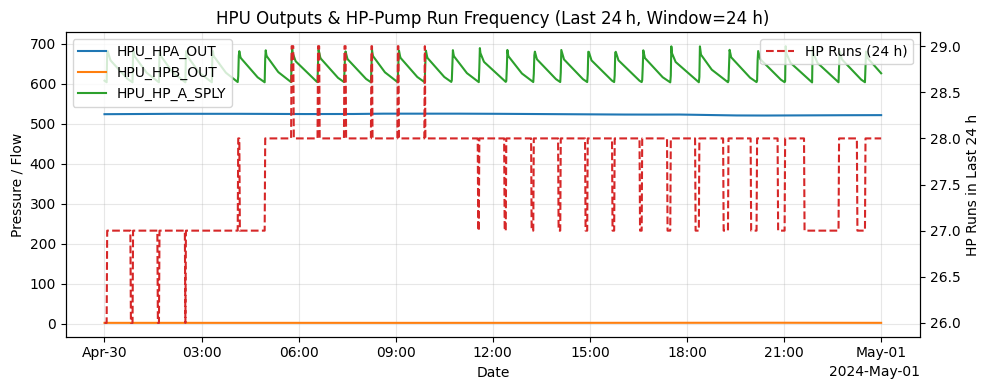

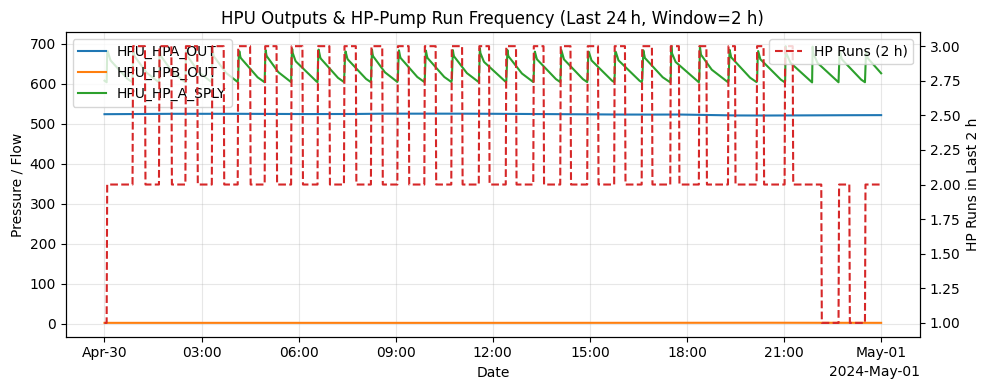

In [36]:

# 0) Ensure df_all_otter is datetime‑indexed & sorted (do this just once)
df_all_otter.index = pd.to_datetime(df_all_otter.index, errors='coerce')
df_all_otter.sort_index(inplace=True)

# 1) Make sure the two HP‑run‐count lags exist
#    (if you already ran the LP version, just mirror it for HP)
df_all_otter['HP_Runs_24h'] = (
    df_all_otter['Cum_HP_Pump_A_Run_Count']
    - df_all_otter['Cum_HP_Pump_A_Run_Count'].shift(1440)
).fillna(0)

df_all_otter['HP_Runs_2h'] = (
    df_all_otter['Cum_HP_Pump_A_Run_Count']
    - df_all_otter['Cum_HP_Pump_A_Run_Count'].shift(120)
).fillna(0)

# 2) Slice out just the last 24 h (tiny chunk, no MemoryError)
end   = df_all_otter.index.max()
start = end - pd.DateOffset(days=1)
df1d  = df_all_otter.loc[start:end].copy()

# 3) Plot both 24 h & 2 h on twin axes
windows = [
    ('24 h', 'HP_Runs_24h'),
    ('2 h',  'HP_Runs_2h' )
]

for label, run_col in windows:
    fig, ax1 = plt.subplots(figsize=(10, 4))

    # Left axis: HPU high-pressure outputs
    ax1.plot(df1d.index, df1d['HPU_HPA_OUT'],    label='HPU_HPA_OUT')
    ax1.plot(df1d.index, df1d['HPU_HPB_OUT'],    label='HPU_HPB_OUT')
    ax1.plot(df1d.index, df1d['HPU_HP_A_SPLY'],  label='HPU_HP_A_SPLY')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Pressure / Flow')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator())
    )

    # Right axis: HP‑pump start counts
    ax2 = ax1.twinx()
    ax2.plot(
        df1d.index,
        df1d[run_col],
        linestyle='--',
        color='tab:red',
        label=f'HP Runs ({label})'
    )
    ax2.set_ylabel(f'HP Runs in Last {label}')
    ax2.legend(loc='upper right')

    plt.title(f'HPU Outputs & HP‑Pump Run Frequency (Last 24 h, Window={label})')
    fig.tight_layout()
    plt.show()


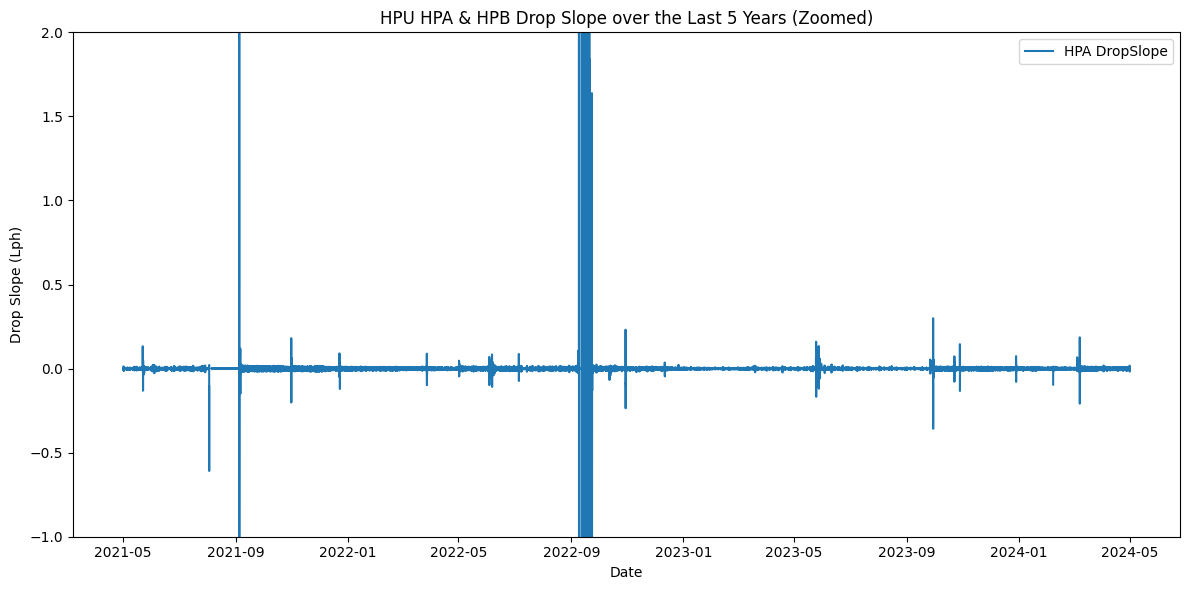

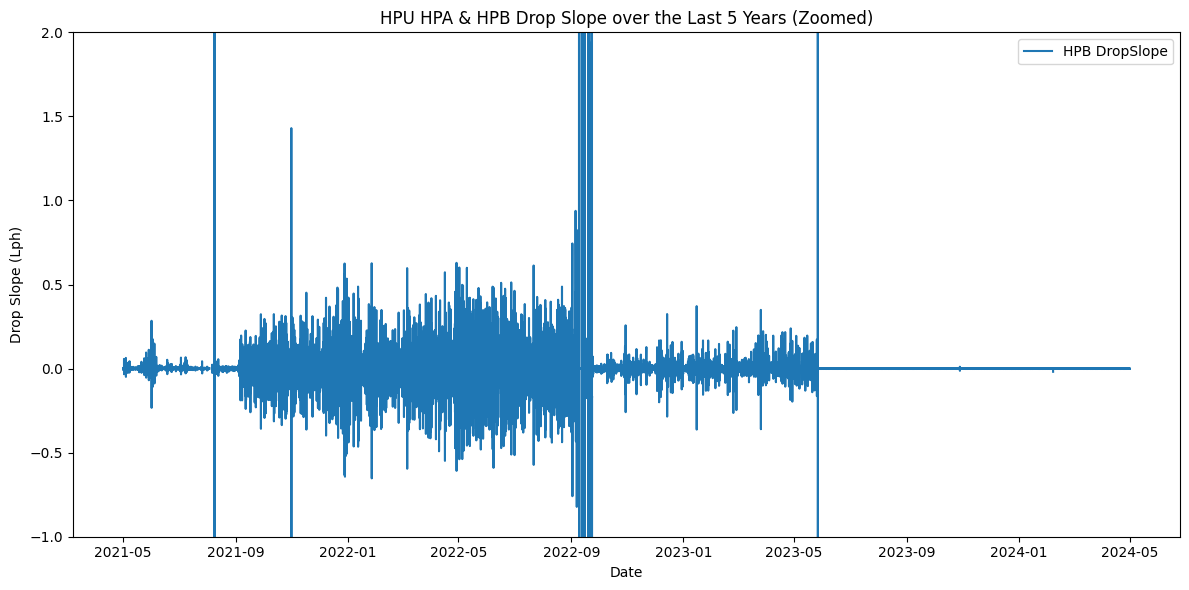

In [37]:
# Plot HPA and HPB 2 hour lag

# Ensure datetime index
if not pd.api.types.is_datetime64_any_dtype(df_all_otter.index):
    df_all_otter.index = pd.to_datetime(df_all_otter['timestamp'])

# Last 5 years window
end_date   = df_all_otter.index.max()
start_date = end_date - pd.DateOffset(years=3)
df_5y = df_all_otter.loc[start_date:end_date, [
    "HPU_HPA_OUT_DropSlope_2h_Lph",
    "HPU_HPB_OUT_DropSlope_2h_Lph"
]]

# Plot with y-axis zoom
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_5y.index, df_5y["HPU_HPA_OUT_DropSlope_2h_Lph"], label="HPA DropSlope")
#ax.plot(df_5y.index, df_5y["HPU_HPB_OUT_DropSlope_8h_Lph"], label="HPB DropSlope")

ax.set_xlabel("Date")
ax.set_ylabel("Drop Slope (Lph)")
ax.set_title("HPU HPA & HPB Drop Slope over the Last 5 Years (Zoomed)")
ax.legend()
ax.set_ylim(-1, 2)    # <-- zoom y-axis between -1 and 2

plt.tight_layout()
plt.show()

# Plot with y-axis zoom
fig, ax = plt.subplots(figsize=(12, 6))
#ax.plot(df_5y.index, df_5y["HPU_HPA_OUT_DropSlope_8h_Lph"], label="HPA DropSlope")
ax.plot(df_5y.index, df_5y["HPU_HPB_OUT_DropSlope_2h_Lph"], label="HPB DropSlope")

ax.set_xlabel("Date")
ax.set_ylabel("Drop Slope (Lph)")
ax.set_title("HPU HPA & HPB Drop Slope over the Last 5 Years (Zoomed)")
ax.legend()
ax.set_ylim(-1, 2)    # <-- zoom y-axis between -1 and 2

plt.tight_layout()
plt.show()


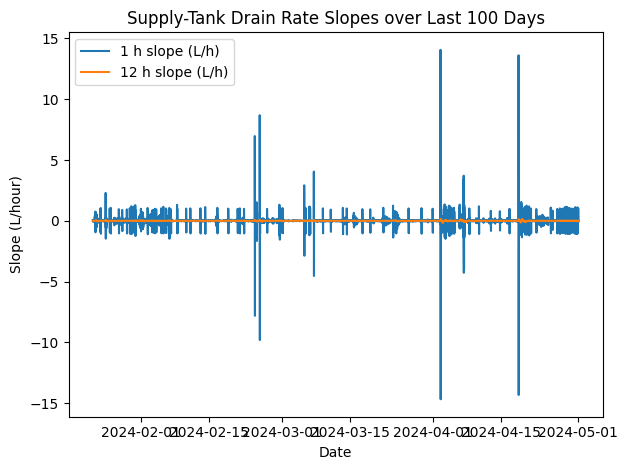

In [38]:

# Plot last 100 days of Supply Tank 1 and 6 hour lags

df = df_all_otter.sort_index()

# 2) Define the 100-day window
end   = df.index.max()
start = end - pd.Timedelta(days=100)
df100 = df.loc[start:end]

# 3) Plot  four slopes 
plt.figure()

plt.plot(df100.index, df100['Slope_1H_Lph'],  label='1 h slope (L/h)')
plt.plot(df100.index, df100['Slope_12H_Lph'],  label='12 h slope (L/h)')

plt.title('Supply-Tank Drain Rate Slopes over Last 100 Days')
plt.xlabel('Date')
plt.ylabel('Slope (L/hour)')
plt.legend()
plt.tight_layout()
plt.show()

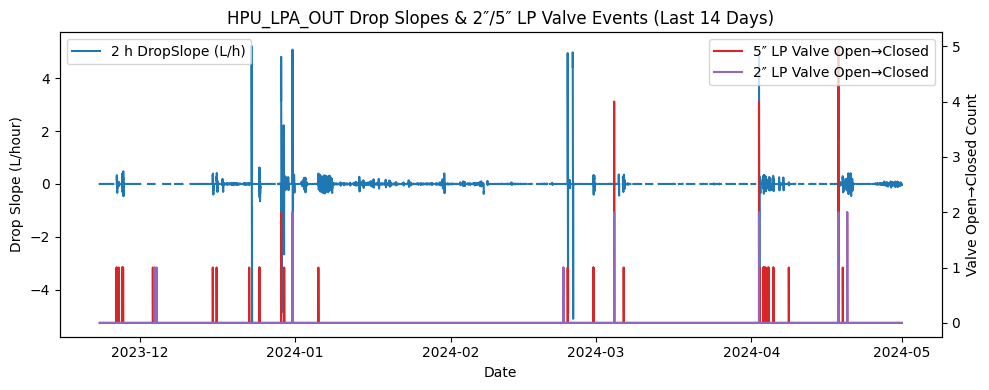

In [39]:
# Plot LPA Drops Slopes with time lag and the LP Valve operations which hsould align

# 1) Prepare your 14-day slice
df = df_all_otter.sort_index()
end   = df.index.max()
start = end - pd.Timedelta(days=160)
df14  = df.loc[start:end]

# 2) Plot the 2h and 24h drop-slopes for HPU_LPA_OUT
fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(df14.index, df14['HPU_LPA_OUT_DropSlope_2h_Lph'],  label='2 h DropSlope (L/h)')
#ax1.plot(df14.index, df14['HPU_LPA_OUT_DropSlope_8h_Lph'], label='24 h DropSlope (L/h)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Drop Slope (L/hour)')
ax1.legend(loc='upper left')

# 3) Overlay the 5″ and 2″ LP-valve counts on a twin axis
ax2 = ax1.twinx()
ax2.step(df14.index,
         df14['5_LP_Valve_OpenToClosed'],
         where='mid',
         color='tab:red',
         label='5″ LP Valve Open→Closed')
ax2.step(df14.index,
         df14['2_LP_Valve_OpenToClosed'],
         where='mid',
         color='tab:purple',
         label='2″ LP Valve Open→Closed')
ax2.set_ylabel('Valve Open→Closed Count')
ax2.legend(loc='upper right')

# 4) Final touches
plt.title('HPU_LPA_OUT Drop Slopes & 2″/5″ LP Valve Events (Last 14 Days)')
plt.tight_layout()
plt.show()

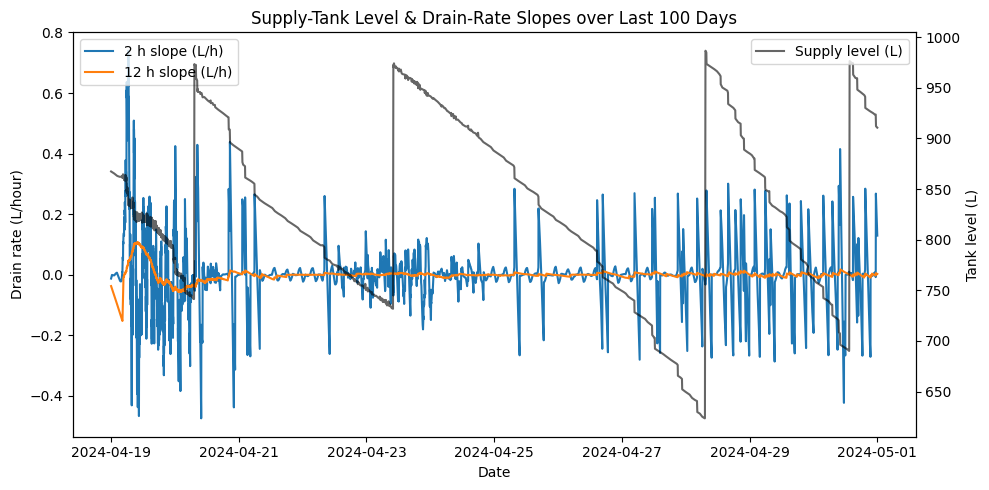

In [40]:
# Plot over 100 days. Include Supply Tank Level and 2 hours and 12 hour time lags. 

# 1) Pick your time window; e.g. last 100 days
df = df_all_otter.sort_index()
end   = df.index.max()
start = end - pd.Timedelta(days=12)
dfw   = df.loc[start:end]

# 2) Start the figure and first axis (for slopes)
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(dfw.index, dfw['Slope_2H_Lph'],  label='2 h slope (L/h)')
ax1.plot(dfw.index, dfw['Slope_12H_Lph'], label='12 h slope (L/h)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Drain rate (L/hour)')
ax1.legend(loc='upper left')

# 3) Twin axis for tank level
ax2 = ax1.twinx()
ax2.plot(dfw.index, dfw['HPU_SPLY_LEV_L'], color='k', alpha=0.6, label='Supply level (L)')
ax2.set_ylabel('Tank level (L)')
ax2.legend(loc='upper right')

# 4) Polish
plt.title('Supply-Tank Level & Drain-Rate Slopes over Last 100 Days')
fig.tight_layout()
plt.show()
